In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# ---------- 1) Load ----------
portfolios5x5 = pd.read_csv('25_Portfolios_5x5_Daily.csv')
reversalFactor = pd.read_csv('F-F_LT_Reversal_Factor_daily.csv')
momentumFactor = pd.read_csv('F-F_Momentum_Factor_daily.csv')
researchData   = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.csv')

for df in [portfolios5x5, reversalFactor, momentumFactor, researchData]:
    df.dropna(inplace=True)
    # divide all return columns (except the date col) by 100
    for c in df.columns[1:]:
        df[c] = pd.to_numeric(df[c], errors='coerce')/100.0
#print(portfolios5x5.head(), portfolios5x5.tail(), reversalFactor.head(), reversalFactor.tail(), momentumFactor.head(), researchData.head(), researchData.tail() )
# ---------- 2) Merge on date ----------
df = portfolios5x5.merge(reversalFactor, on='Unnamed: 0') \
                  .merge(momentumFactor, on='Unnamed: 0') \
                  .merge(researchData,   on='Unnamed: 0')

# ---------- 3) Basic cleaning ----------
df = df.rename(columns={'Unnamed: 0':'Date'})
df['Date'] = pd.to_datetime(df['Date'].astype(str), format='%Y%m%d')

# keep 2008+
df = df[df['Date'] >= '2008-01-01'].copy()

for c in df.columns:
    if c != 'Date':
        df = df[df[c].abs() < 1]

#print(df.head(), df.tail())
df = df.set_index('Date').sort_index()

# ---------- 4) Daily → Monthly (compounded) ----------
def compound_month(x):
    return (1.0 + x).prod() - 1.0

monthly = df.resample('M').apply(compound_month).dropna()
#display(monthly)
# ---------- 5) OLS for one portfolio ----------
port_col = 'SMALL HiBM'  # pick any of the 25 columns you want
monthly['ExcessRet'] = monthly[port_col] - monthly['RF']

X = monthly[['Mkt-RF','SMB','HML','RMW','CMA','Mom']]
X = sm.add_constant(X)                # intercept = alpha
y = monthly['ExcessRet']

ols = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':3})
print(ols.summary())
print('Monthly alpha (const):', float(ols.params['const']))


C:\Users\creat\AppData\Local\Temp\ipykernel_18636\1365246018.py:6: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  portfolios5x5 = pd.read_csv('25_Portfolios_5x5_Daily.csv')
C:\Users\creat\AppData\Local\Temp\ipykernel_18636\1365246018.py:40: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.resample('M').apply(compound_month).dropna()


                            OLS Regression Results                            
Dep. Variable:              ExcessRet   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     177.9
Date:                Mon, 18 Aug 2025   Prob (F-statistic):           5.44e-78
Time:                        05:53:50   Log-Likelihood:                 312.07
No. Observations:                 210   AIC:                            -610.1
Df Residuals:                     203   BIC:                            -586.7
Df Model:                           6                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0172      0.004      4.002      0.0

In [ ]:
import pymc as pm
import xarray as xr
import arviz as az


def prep_Xy(X, y, eps=1e-8):
    # ensure arrays
    X = np.asarray(X, float)
    y = np.asarray(y, float)

    # drop rows with any non-finite values
    mask = np.isfinite(X).all(1) & np.isfinite(y)
    X, y = X[mask], y[mask]

    # de-mean and standardize with eps (avoid divide-by-zero)
    X_mean = X.mean(0)
    X_std  = X.std(0, ddof=1)
    X_std[X_std < eps] = 1.0  # protect constant cols

    y_mean = y.mean()
    y_std  = y.std(ddof=1)
    if y_std < eps:  # protect near-constant target
        y_std = 1.0

    Xz = (X - X_mean) / X_std
    yz = (y - y_mean) / y_std

    # clip extreme z-scores (helps VI)
    Xz = np.clip(Xz, -8.0, 8.0)
    yz = np.clip(yz, -8.0, 8.0)

    return Xz, yz, (X_mean, X_std, y_mean, y_std)

Xz, yz, scales = prep_Xy(X, y)  # your X (factors), y (EXCESS returns)
n, p = Xz.shape
X_mean, X_std, y_mean, y_std = scales

with pm.Model() as hs_model:
    # Intercept in standardized space
    alpha = pm.Normal("alpha", mu=0.0, sigma=5.0)

    # STABLE shrinkage (HalfNormal instead of HalfCauchy)
    tau = pm.HalfNormal("tau", sigma=1.0)                # global
    lam = pm.HalfNormal("lambda", sigma=1.0, shape=p)    # local

    beta = pm.Normal("beta", mu=0.0, sigma=tau * lam, shape=p)

    # Observation noise (std) — HalfNormal is VI-friendly
    sigma = pm.HalfNormal("sigma", sigma=1.0)

    mu = alpha + pm.math.dot(Xz, beta)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=yz)

    # ADVI with convergence check
    advi = pm.fit(
        30000,
        method="advi",
        callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-3)]
    )
    trace = advi.sample(2000)

post = trace.posterior
alpha_z = float(post["alpha"].mean(("chain","draw")))
beta_z  = post["beta"].mean(("chain","draw")).values
lam_m   = post["lambda"].mean(("chain","draw")).values

# Inclusion-like importance (smaller lam => less shrinkage)
importance = 1.0 / (1.0 + lam_m**2)

# Unstandardize back to original units
beta_unstd  = beta_z * (y_std / X_std)
alpha_unstd = y_mean + y_std * (alpha_z - (X_mean / X_std) @ beta_z)

print("alpha (original units):", alpha_unstd)
print("beta  (original units):", beta_unstd)
print("importance (0≈excluded, 1≈kept):", importance)


Output()

Finished [100%]: Average Loss = 127.61


alpha (original units): 0.022635713386688853
beta  (original units): [-0.00572421  0.82425322  1.06690441  0.07649407 -0.24649025  0.60188616
 -0.22497292]
importance (0≈excluded, 1≈kept): [0.50033769 0.48650339 0.53586674 0.82712889 0.7580282  0.69887708
 0.71176812]


In [ ]:
with hs_model:
    idata_hs = pm.sample(
        draws=500, tune=500, target_accept=0.9,
        idata_kwargs={"log_likelihood": True},
        chains=4, cores=4
    )

waic_val = az.waic(idata_hs)
print(waic_val)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, tau, lambda, beta, sigma]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 355 seconds.
There were 123 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Computed from 2000 posterior samples and 210 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -121.01    60.53
p_waic       29.98        -

There has been a warning during the calculation. Please check the results.


c:\Users\creat\AppData\Local\Programs\Python\Python312\Lib\site-packages\arviz\stats\stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


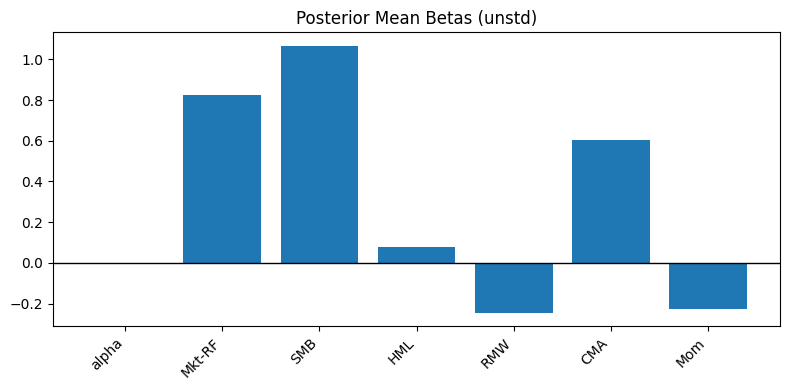

In [58]:
factor_names = ["alpha"] + list(X.columns[1:])
fig_beta, ax_beta = plt.subplots(figsize=(8,4))
ax_beta.bar(range(len(beta_unstd)), beta_unstd)
ax_beta.axhline(0, lw=1, color='k')
ax_beta.set_xticks(range(len(beta_unstd)))
ax_beta.set_xticklabels(factor_names, rotation=45, ha='right')
ax_beta.set_title("Posterior Mean Betas (unstd)")
plt.tight_layout()
plt.show()


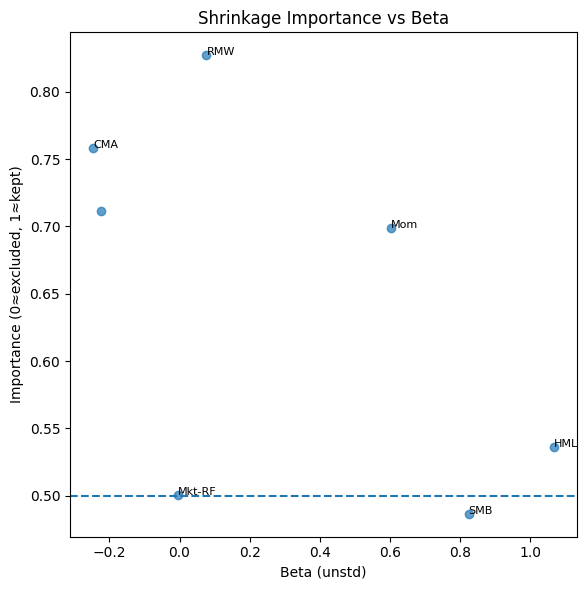

In [59]:
fig_imp, ax_imp = plt.subplots(figsize=(6,6))
ax_imp.scatter(beta_unstd, importance, alpha=0.7)
for i, lbl in enumerate(X.columns[1:]):
    ax_imp.text(beta_unstd[i], importance[i], lbl, fontsize=8)
ax_imp.axhline(0.5, ls="--")
ax_imp.set_xlabel("Beta (unstd)")
ax_imp.set_ylabel("Importance (0≈excluded, 1≈kept)")
ax_imp.set_title("Shrinkage Importance vs Beta")
plt.tight_layout()
plt.show()

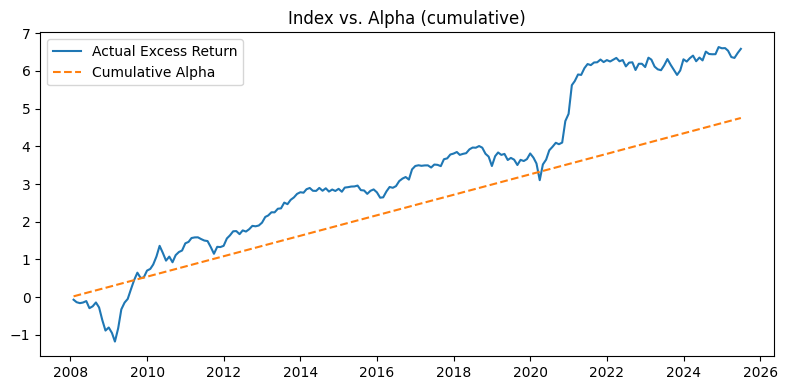

In [ ]:
cum_y_series   = pd.Series(np.cumsum(y), index=monthly.index)
cum_alpha_line = pd.Series(np.cumsum(np.full(len(y), alpha_unstd)), index=monthly.index)

fig_cum, ax_cum = plt.subplots(figsize=(8,4))
ax_cum.plot(cum_y_series, label="Actual Excess Return")
ax_cum.plot(cum_alpha_line, label="Cumulative Alpha", ls="--")
ax_cum.legend()
ax_cum.set_title("Index vs. Alpha (cumulative)")
plt.tight_layout()
plt.show()


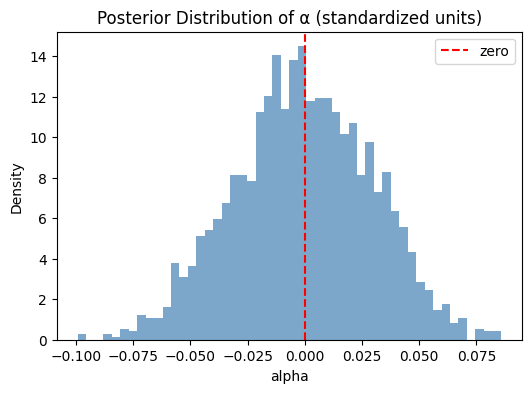

In [62]:
import matplotlib.pyplot as plt

# flatten all chains/draws into one array
alpha_samples = trace.posterior["alpha"].values.flatten()

plt.figure(figsize=(6,4))
plt.hist(alpha_samples, bins=50, density=True, alpha=0.7, color="steelblue")
plt.axvline(0, color="red", linestyle="--", label="zero")
plt.title("Posterior Distribution of α (standardized units)")
plt.xlabel("alpha")
plt.ylabel("Density")
plt.legend()
plt.show()


In [64]:
n, p = Xz.shape  # n observations, p predictors

with pm.Model() as tv_model:
    # Precision priors (use sigma instead of tau)
    sigma_alpha = pm.Exponential("sigma_alpha", 10.0)   # ~1/sqrt(Gamma)
    sigma_e     = pm.Exponential("sigma_e", 10.0)
    sigma_beta  = pm.Exponential("sigma_beta", 10.0, shape=p)
    
    # Random walk for alpha (length n)
    alpha = pm.GaussianRandomWalk("alpha", sigma=sigma_alpha, shape=n)
    
    # Random walks for each beta_j (shape n x p)
    betas = []
    for j in range(p):
        beta_j = pm.GaussianRandomWalk(f"beta_{j}", sigma=sigma_beta[j], shape=n)
        betas.append(beta_j)
    betas = pm.math.stack(betas, axis=1)  # shape (n, p)

    # Linear predictor
    mu = alpha + pm.math.sum(Xz * betas, axis=1)

    # Observation model
    y_like = pm.Normal("y_obs", mu=mu, sigma=sigma_e, observed=yz)

with tv_model:
    idata = pm.sample(
        draws=200,          # number of posterior draws per chain
        tune=100,           # warmup (adaptation) steps
        chains=4,           # run 4 parallel chains
        cores=4,            # use 4 CPU cores
        target_accept=0.9,  # keep this high to avoid divergences
        random_seed=42
    )

c:\Users\creat\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\distributions\timeseries.py:290: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
c:\Users\creat\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\distributions\timeseries.py:290: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
c:\Users\creat\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\distributions\timeseries.py:290: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
c:\Users\creat\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\distributions\timeseries.py:290: UserWarning: Initial distribution not specified, defaultin

Output()

Sampling 4 chains for 100 tune and 200 draw iterations (400 + 800 draws total) took 16824 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


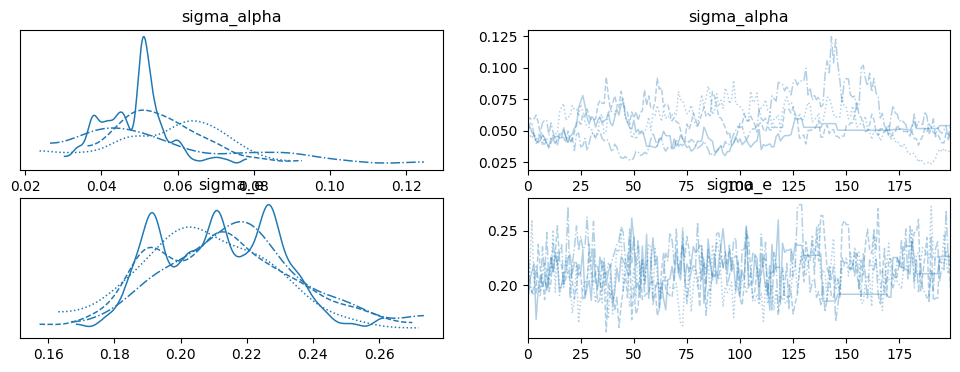

In [65]:
az.summary(idata, var_names=["sigma_alpha","sigma_e","sigma_beta"])
az.plot_trace(idata, var_names=["sigma_alpha","sigma_e"]);


In [66]:
# posterior samples: (chain, draw, time)
alpha_post = idata.posterior["alpha"]
alpha_mean_t = alpha_post.mean(("chain","draw")).values        # ᾱ_t  (time series)
alpha_prob_pos_t = (alpha_post > 0).mean(("chain","draw")).values  # P(α_t > 0) per time

# if you have a Date index for your data:
idx = pd.Index(dates_array, name="Date")   # same length as n
alpha_mean = pd.Series(alpha_mean_t, index=idx)
prob_pos   = pd.Series(alpha_prob_pos_t, index=idx)
alpha_mean.plot(title="Posterior mean alpha over time");
prob_pos.plot(title="P(alpha_t > 0) over time");  # “prob_pos vs index”


NameError: name 'dates_array' is not defined

In [ ]:
# collect each beta_j(t) series
beta_means = {}
for j in range(p):
    b = idata.posterior[f"beta_{j}"]                         # (chain, draw, time)
    beta_means[j] = pd.Series(b.mean(("chain","draw")).values, index=idx)

# example: plot one factor at a time
beta_means[0].plot(title="β_0(t) over time");
# or all on one figure (careful with clutter)
ax = None
for j, s in beta_means.items():
    ax = s.plot(ax=ax, label=f"beta_{j}")
ax.legend(); ax.set_title("Time-varying betas");


In [ ]:
az.waic(idata)